# Feature Extraction

## Power Sensor

## Power source

In [83]:
# imports
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_welch
from IPython.display import clear_output

In [74]:
#### constant variables to be used in the code ####

# sampling rate
sfreq = 512

# frequency bands of interest
frequencies = {'delta': (1, 3.875),
               'theta': (4, 7.875),
               'alpha': (8, 12.875),
               'beta': (13, 30),
               'lowgamma': (30.125, 42) 
}
# bands = Bands(frequencies)

# labels for the psd table based on Yeo2011 7 networks
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

labels_ = [yeo7[k] + '_' + hemisferes[i] 
           for k in yeo7.keys() 
           for i in range(len(hemisferes))]



#### helper function to be used in the code ####

# get dataframe of powers for each frequency band
def get_power_bands_df(psds, freqs, labels=labels_):
    
    # initiate a dictionary to store power from each band
    psds_bands = {}
    
    # average the power over each band
    for k in frequencies.keys():
        temp = psds[:, np.where((frequencies[k][0] <= freqs) & (freqs <= frequencies[k][1]) == True)[0]]
        psds_bands[k] = temp.mean(1)
    
    # create and return a dataframe with the power from each band across all networks
    df = pd.DataFrame.from_dict(psds_bands, orient='index', columns=labels).T.stack().reset_index()
    df['new_col'] = df['level_0'] + '_' + df['level_1']
    df.drop(['level_0', 'level_1'], axis=1, inplace=True)
    
    return df.set_index('new_col').T

In [84]:
#### extract PSD features on parcellated source data ####

# initialize a dataframe to store PSD features for all subjects
psd_df = pd.DataFrame()

# open the parcellated source data
for subject_path in sorted(Path('data/parcellated_source_yeo7').glob('*.npz')):
  
  subject, task = re.search('(.*)_task-(.*)_labels.*', subject_path.stem).groups()
  
  if task.__contains__('experience'):

    label_ts = np.load(subject_path)['labels']
  
    # create a continuous data array from the parcellated source data
    label_continious = np.hstack(np.array(label_ts))

    # calculate psd on continuous data
    psds, freqs = psd_array_welch(label_continious,
                                  sfreq=sfreq,
                                  fmin=1,
                                  fmax=42,
                                  n_fft=4096, # window size is 4096/512 = 8s
                                  n_overlap=2048, # 50% overlap
                                  n_jobs=1)

    # extract periodic parameters
    df_periodic = get_power_bands_df(psds, freqs=freqs)
    
    # reindex the dataframe
    index = subject[4:] + '_' + task
    df_periodic.index = [index]
    
    # append to the main dataframe
    psd_df = pd.concat([psd_df, df_periodic], axis=0)
  
    clear_output()

In [ ]:
# create a classification dataframe
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')
bh = bh.iloc[:208]

# open power data
psd_df[['bids_id', 'condition']] = psd_df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
psd_df['session'] = psd_df['condition'].apply(lambda x:x[-1]) 
psd_df.reset_index(drop=True, inplace=True)
psd_df['session'] = psd_df['session'].astype('int64')
psd_df = pd.merge(bh, psd_df, how='right', on=['session', 'bids_id'], right_index=False)
psd_df = psd_df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
psd_df.insert(1, 'condition', psd_df.pop('condition'))
psd_df.head()

# psd_df.to_csv('data/classification_datasets/power_source_2nd.csv', index=0)

In [ ]:
# classification
# imports
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score, cross_validate)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC

# load grid results from 
grid_results = pd.read_csv('data/classification_results/grid_results.csv')  
grid_results = grid_results.query('param_extract__kind == "power source"') # only power source grid results
grid_results['label'] = grid_results['param_extract__frequency_band'] + ' ' + grid_results['param_extract__kind']
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx].reset_index()
params = grid_results[['label', 'mean_test_score', 'std_test_score', 'param_select', 'param_clf__C']]

In [149]:
power = pd.read_csv('data/classification_datasets/power_source_2nd.csv', index_col=0)

# remove subject 52
power = power.iloc[:204]

# get only hypnosis conditions
power = power.query('description == "hypnosis"')

# output feature
y = power['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)

# input features
col_name = [i for i in power.columns if 'gamma' in i]
X = power[col_name]

# transform data
# X = X.apply(lambda x:x*(100)**12) #yoctovolt

# CV and groups
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
groups = power['bids_id']

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(estimator=SVC(kernel='linear'))),
    ('clf', LinearSVC(max_iter=1000000, C=0.1, dual=True, class_weight='balanced')),
])

scores = cross_val_score(pipe, X, y, groups=groups, scoring='accuracy', cv=CV, n_jobs=-1)
scores.mean(), scores.std()

(0.5713872855405464, 0.11247318434830475)

In [109]:
params

,label,mean_test_score,std_test_score,param_select,param_clf__C
0,delta power source,0.472424,0.103795,passthrough,0.1
1,theta power source,0.496234,0.103916,passthrough,0.1
2,alpha power source,0.528788,0.102435,passthrough,0.1
3,beta power source,0.526028,0.104040,SelectFromModel(estimator=SVC(kernel='linear')),1.0
4,gamma power source,0.545747,0.109029,SelectFromModel(estimator=SVC(kernel='linear')),5.0


Accuracy in this new dataset is not different than the previous analysis.
Accuracy of the non-logarithmic transformed data is higher and closer to the random (0.57).

# Correlation Sensor

In [1]:
import pickle
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from mne_connectivity import envelope_correlation
from IPython.display import clear_output

In [29]:
frequencies = {'delta': (1, 3.875),
               'theta': (4, 7.875),
               'alpha': (8, 12.875),
               'beta': (13, 30),
               'lowgamma': (30.125, 42)}

frequencies = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'lowgamma': (30, 42)  
}

# Envelope Correlation
def get_connectivity(epochs,
                     frequencies: dict,
                     sfreq: float = 1000,
):
    # drop useless channels
    epochs.drop_channels(ch_names=['M1', 'M2', 'EOG1', 'EOG2', 'ECG'])
    
    def bp_gen(raw, fmin, fmax, sfreq):
        yield mne.filter.filter_data(raw, sfreq=sfreq, l_freq=fmin, h_freq=fmax)
    
    # each segment in epochs is 1 second
    # To compute the connectivity, we want segments that its lenght is about 30 seconds (or a bit less)
    raw = np.array([np.hstack(epochs.get_data())])
    # epochs = np.array_split(raw, 10, axis=1)
    
    conns = {} 
    for bp in frequencies.keys():
        conn_obj = envelope_correlation(bp_gen(raw, frequencies[bp][0], frequencies[bp][1], sfreq),
                                               orthogonalize='pairwise')
        conn = conn_obj.combine()
        conn = conn.get_data(output='dense')[..., 0]
        conns[bp] = conn
        
    return conns

In [34]:
path = sorted(Path('data/clean_data').glob('*.fif'))[11]

# open epochs
epochs = mne.read_epochs(path, preload=True)

# set montage
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)
    
# surface laplacian
# epochs_csd = mne.preprocessing.compute_current_source_density(epochs)

# compute connectivity
# conn_with_laplacian = get_connectivity(epochs, frequencies)

epochs.drop_channels(ch_names=['M1', 'M2', 'EOG1', 'EOG2', 'ECG'])
    
def bp_gen(raw, fmin, fmax, sfreq):
    for ts in raw:
        yield mne.filter.filter_data(ts, sfreq=sfreq, l_freq=fmin, h_freq=fmax)

# each segment in epochs is 1 second
# To compute the connectivity, we want segments that its lenght is about 30 seconds (or a bit less)
raw = np.array([np.hstack(epochs.get_data())])
# epochs = np.array_split(raw, 10, axis=1)

conns = {} 
for bp in frequencies.keys():
    conn_obj = envelope_correlation(bp_gen(raw, frequencies[bp][0], frequencies[bp][1], sfreq=1000),
                                    orthogonalize='pairwise')
    conn = conn_obj.combine()
    conn = conn.get_data(output='dense')[..., 0]
    conns[bp] = conn


Reading /Users/yeganeh/Codes/SuggNet/data/clean_data/sub-02_ses-01_task-baseline2_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

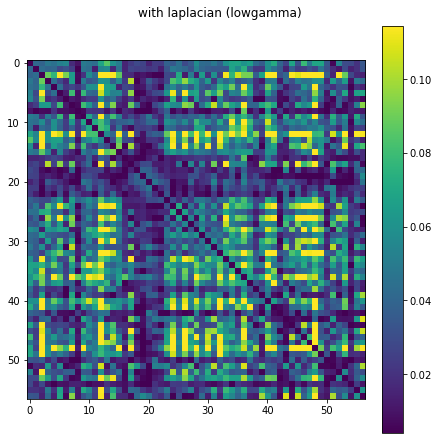

In [28]:
def plot_corr(corr, title):
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
        shw = ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
        fig.suptitle(title)
        plt.colorbar(shw)

key = 'lowgamma'
plot_corr(conns[key], f'with laplacian ({key})')

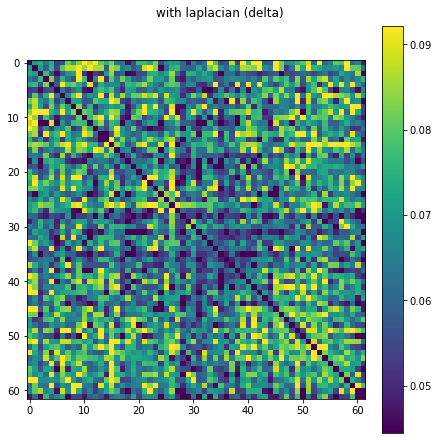

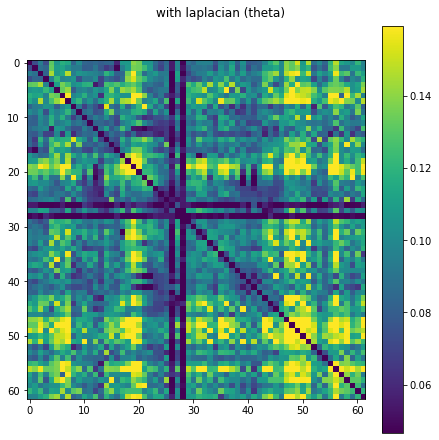

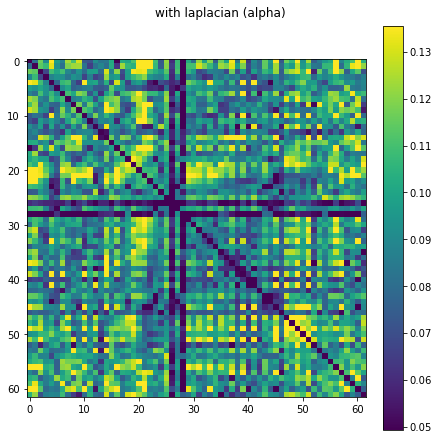

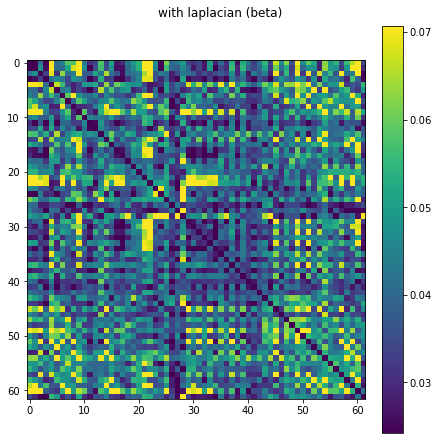

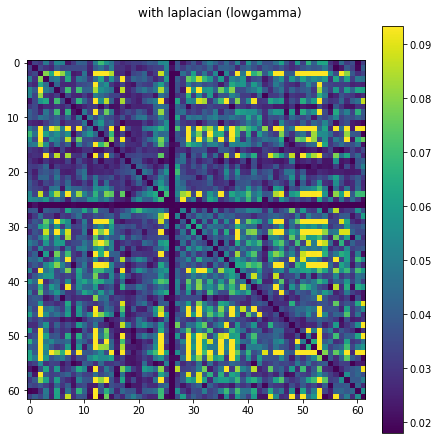

In [5]:
def plot_corr(corr, title):
        fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
        shw = ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
        fig.suptitle(title)
        plt.colorbar(shw)

for key in frequencies.keys():
    plot_corr(conn_with_laplacian[key], f'with laplacian ({key})')
#     plot_corr(conn[key], f'with laplacian ({key})')

In [ ]:
for subject_path in sorted(Path('data/clean_data').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo', subject_path.name).groups()
    
    connectivity_path = f'data/connectivities/correlation_sensor/{subject}_task-{task}_conn-corr_sensor_filtered.pkl'
    if Path(connectivity_path).exists():
        continue
    
    print('>>>>>>>>', subject, task)
    if task == 'baseline2' or 'induction' in task:
        continue

    # open epochs
    epochs = mne.read_epochs(subject_path, preload=True)
    
    # set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)
      
    # surface laplacian
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    
    # compute connectivity
    conn = get_connectivity(epochs_csd, frequencies)

    # save connectivity
    with open(connectivity_path, 'wb') as f:
        pickle.dump(conn, f)
        
    clear_output()